# Setup

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [53]:
os.chdir(root+ "/functions")
import modelling

In [54]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 03 Regularize

Now that I made sure that the model can actually perform the task, I want to make it more generic and improve validation / test set performance. I expect that obviously the performance of the training set will decrease due to less overfitting.


- Data Augmentation
- Early Stopping

In custom models I will tryout Dropout and Batch Normalization as well.
Also I might generally add more data since my dataset is quite small.

In [55]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 477 files belonging to 3 classes.
Using 382 files for training.


In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 477 files belonging to 3 classes.
Using 95 files for validation.


In [57]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_test,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=False,
)

Found 117 files belonging to 3 classes.


In [58]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
# data augmentation pipeline
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(HEIGHT,WIDTH,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [60]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [61]:
mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))
model = modelling.recompile_model(mobileNet, 'adam', 'categorical_crossentropy')

In [62]:
callbacks = EarlyStopping(monitor='val_loss', mode = "min", patience=5)

In [63]:
epochs=35
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  callbacks = callbacks
)

Epoch 1/35
12/12 [==============================] - 26s 2s/step - loss: 1.9416 - accuracy: 0.3979 - val_loss: 1.0172 - val_accuracy: 0.5579
Epoch 2/35
12/12 [==============================] - 24s 2s/step - loss: 0.9657 - accuracy: 0.5628 - val_loss: 0.8297 - val_accuracy: 0.6526
Epoch 3/35
12/12 [==============================] - 22s 2s/step - loss: 0.7846 - accuracy: 0.6152 - val_loss: 0.7758 - val_accuracy: 0.6526
Epoch 4/35
12/12 [==============================] - 24s 2s/step - loss: 0.6881 - accuracy: 0.6990 - val_loss: 0.7630 - val_accuracy: 0.6737
Epoch 5/35
12/12 [==============================] - 23s 2s/step - loss: 0.6690 - accuracy: 0.7068 - val_loss: 0.7681 - val_accuracy: 0.6421
Epoch 6/35
12/12 [==============================] - 24s 2s/step - loss: 0.6307 - accuracy: 0.7120 - val_loss: 0.7359 - val_accuracy: 0.6947
Epoch 7/35
12/12 [==============================] - 24s 2s/step - loss: 0.5883 - accuracy: 0.7539 - val_loss: 0.6996 - val_accuracy: 0.7053
Epoch 8/35
12/12 [==

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<ipython-input-69-ea08502b937f>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


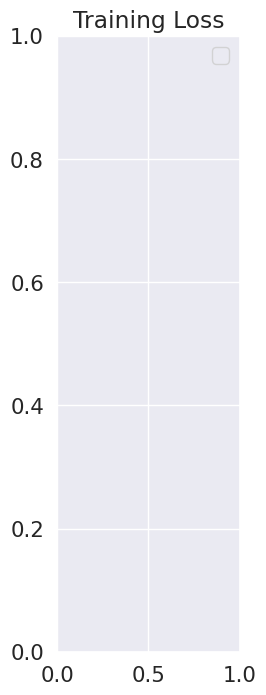

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, loss, label='Training Loss')


plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 3, 2)

#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [70]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = modelling.extract_labels_categorical(train_ds)

12/12 [==============================] - 21s 1s/step


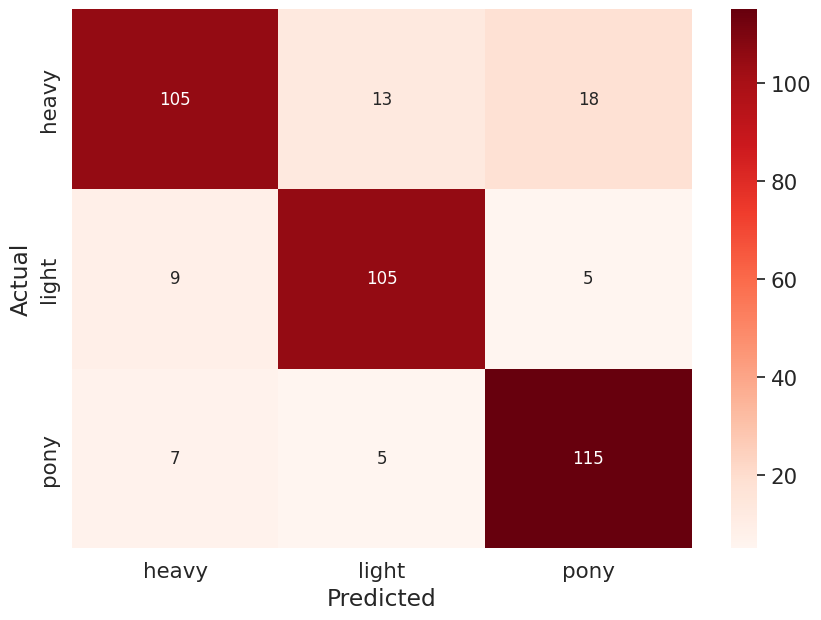

In [71]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
modelling.plot_cm(confusion_matrix_train, class_names)

In [72]:
print(classification_report(train_true_labels,train_predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       136
           1       0.85      0.88      0.87       119
           2       0.83      0.91      0.87       127

    accuracy                           0.85       382
   macro avg       0.85      0.85      0.85       382
weighted avg       0.85      0.85      0.85       382



In [73]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = modelling.extract_labels_categorical(val_ds)

3/3 [==============================] - 3s 979ms/step


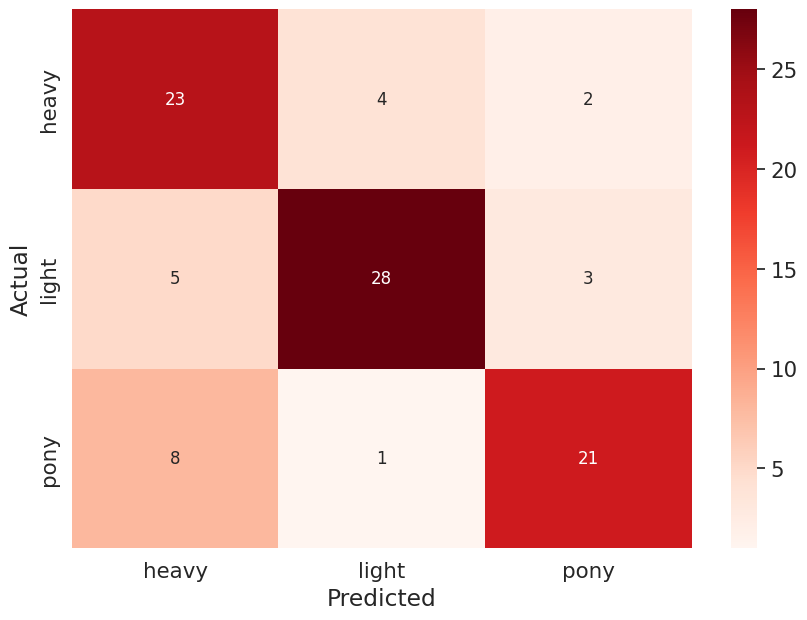

In [74]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
modelling.plot_cm(confusion_matrix_val, class_names)

In [75]:
print(classification_report(val_true_labels,val_predicted_labels))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71        29
           1       0.85      0.78      0.81        36
           2       0.81      0.70      0.75        30

    accuracy                           0.76        95
   macro avg       0.77      0.76      0.76        95
weighted avg       0.77      0.76      0.76        95



In [76]:
testset_predictions = model.predict(test_ds)
test_predicted_labels = [prediction.argmax() for prediction in testset_predictions]
test_true_labels = modelling.extract_labels_categorical(test_ds)

4/4 [==============================] - 4s 887ms/step


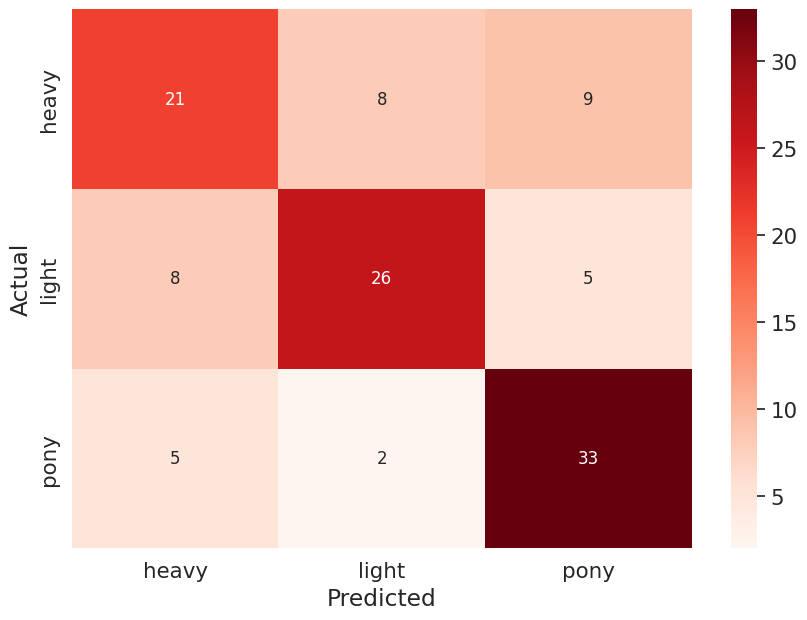

In [77]:
confusion_matrix_test = np.array(tf.math.confusion_matrix(test_true_labels, test_predicted_labels))
confusion_matrix_test = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
modelling.plot_cm(confusion_matrix_test, class_names)

In [78]:
print(classification_report(test_true_labels,test_predicted_labels))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58        38
           1       0.72      0.67      0.69        39
           2       0.70      0.82      0.76        40

    accuracy                           0.68       117
   macro avg       0.68      0.68      0.68       117
weighted avg       0.68      0.68      0.68       117



# Summary

Regularizing works in general! The performance of the training dataset
decreased as overfitting was reduced. Meanwhile the validation and testset performance rose significantly. This experiment was sucessful, even though I could do much more here. In a next step I want to look at different models and fine tune each of them suiting their needs with the general approach of this built pipeline.